![CAT_DOG](img/bannière.png)

# 📌 Contexte du projet

Une équipe médicale souhaite explorer l'apport de l'intelligence artificielle dans le diagnostic automatisé de la **pneumonie** à partir de **radios thoraciques**.

🎯 Objectif :
Développer un **prototype fonctionnel (Proof of Concept)** capable de **classer automatiquement** une image en :
- Pneumonie
- Pas de pneumonie

Le système repose sur la **réutilisation d’un modèle pré-entraîné** de type CNN (réduction du coût d’entraînement).  
Le modèle choisi est **DenseNet121**, avec les **poids CheXNet** (entraînés sur le jeu de données ChestX-ray14), adaptés à la classification médicale.

🛠️ Suivi des expériences :  
Le projet intègre **MLflow** pour le suivi des essais, la traçabilité des modèles et les performances dans une logique **MLOps**.



- modèle à utiliser: CheXNet (ou le réseau de neuronne qui à permis de le faire : Densenet121)

## 📦 1. Chargement des bibliothèques nécessaires

Dans cette section, nous importons toutes les bibliothèques utiles pour :

- la gestion des données et des images (`numpy`,`matplotlib`, etc.),
- la construction et le chargement du modèle (`keras`),
- le suivi des expérimentations avec `MLflow`.

Nous utilisons `TensorFlow/Keras` comme framework principal pour l'entraînement.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from datetime import datetime
from time import strftime
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
import tempfile
from mlflow.models.signature import infer_signature

#librairie tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

#librairie mlflow
import mlflow
import mlflow.tensorflow

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

2025-05-23 16:39:14.055690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748011154.107996   99690 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748011154.123434   99690 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748011154.194155   99690 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748011154.194218   99690 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748011154.194220   99690 computation_placer.cc:177] computation placer alr

In [2]:
IMAGE_PIXEL = (224, 224)

## 🖥️ Vérification utilisation carte graphique



In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print(f"Nom du GPU détecté : {gpu.name}")
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} GPU(s) physique(s), {len(logical_gpus)} GPU(s) logique(s)")
        
        # Afficher les infos depuis le runtime TensorFlow
        from tensorflow.python.client import device_lib
        devices = device_lib.list_local_devices()
        for device in devices:
            if device.device_type == 'GPU':
                print("Nom      :", device.name)
                print("Type     :", device.device_type)
                print("Mémoire  :", round(device.memory_limit / (1024**3), 2), "GB")
                print("---------")
    except RuntimeError as e:
        print(e)
else:
    print("Aucun GPU détecté.")

Num GPUs Available:  1
Nom du GPU détecté : /physical_device:GPU:0
1 GPU(s) physique(s), 1 GPU(s) logique(s)
Nom      : /device:GPU:0
Type     : GPU
Mémoire  : 5.43 GB
---------


I0000 00:00:1748011157.485091   99690 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1748011157.498700   99690 gpu_device.cc:2019] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## 🔍 2. Exploration des données

Nous examinons la structure du jeu de données en visualisant les classes présentes (ex: `PNEUMONIA`, `NORMAL`) et quelques exemples d’images.

Cela permet de vérifier que les données sont bien organisées et de se faire une idée de leur contenu avant le prétraitement.


Classes disponibles : ['NORMAL', 'PNEUMONIA']
Classe : NORMAL
Type des valeurs : uint8
Shape (dimensions)    : (1312, 1395, 3)
Type des valeurs      : uint8


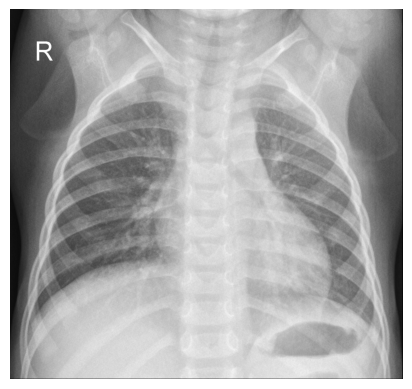

Classe : PNEUMONIA
Type des valeurs : uint8
Shape (dimensions)    : (1016, 1248, 3)
Type des valeurs      : uint8


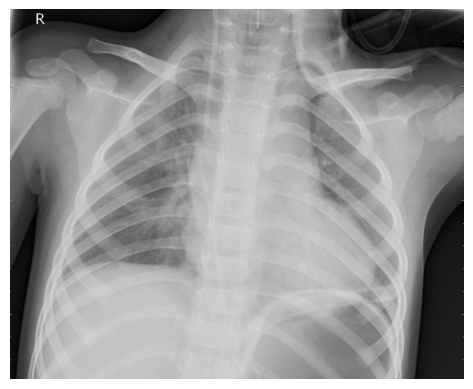

In [4]:
data_dir = "data/train"

classes = os.listdir(data_dir)
print("Classes disponibles :", classes)

for label in classes:
    path = os.path.join(data_dir, label)
    sample_img = random.choice(os.listdir(path))
    img = cv2.imread(os.path.join(path, sample_img), cv2.IMREAD_COLOR_RGB) #IMREAD_COLOR_RGB
    print(f"Classe : {label}")
    print(f"Type des valeurs : {img.dtype}")
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    # Inspection des métadonnées de l'image
    print(f"Shape (dimensions)    : {img.shape}")
    print(f"Type des valeurs      : {img.dtype}")
    plt.show()

## 🧹 3. Préparation des données

Nous utilisons un générateur de données (`ImageDataGenerator`) pour :

- redimensionner les images à la taille attendue par le modèle (224x224),
- effectuer une normalisation simple (rescale),
- créer un split automatique entre **données d'entraînement** et **données de validation** (20%).

Les images sont converties en **RGB**, car le modèle préentraîné attend 3 canaux d’entrée.


## 🧪 4. Preprocessing

Le prétraitement est effectué automatiquement par `ImageDataGenerator`, avec les étapes suivantes :

- redimensionnement des images (224x224),
- conversion en 3 canaux (RGB),
- effectuer une normalisation simple (rescale)
- normalisation des pixels (entre 0 et 1).

Les images sont converties en **RGB**, car le modèle préentraîné attend 3 canaux d’entrée.
Ces transformations sont nécessaires pour que les images soient compatibles avec le modèle DenseNet121.

Ces modifications sont faites pour les 3 dataset qui sont:
- test
- train
- val

In [5]:
# Prétraitement commun
datagen = ImageDataGenerator(rescale=1./255)

# Générateur pour l'entraînement
train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(IMAGE_PIXEL[0], IMAGE_PIXEL[1]),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Générateur pour le test final
test_generator = datagen.flow_from_directory(
    'data/test',
    target_size=(IMAGE_PIXEL[0], IMAGE_PIXEL[1]),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Générateur pour la validation
val_generator = datagen.flow_from_directory(
    'data/val',
    target_size=(IMAGE_PIXEL[0], IMAGE_PIXEL[1]),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## 🧠 5. Modélisation

Nous utilisons le modèle **DenseNet121** disponible dans `Keras`, sans ses poids par défaut (`weights=None`), et nous le complétons avec une couche de classification binaire.

Ensuite, nous **chargeons les poids préentraînés de CheXNet**, disponibles au format `.h5`.  
Ces poids proviennent d’un entraînement sur un grand jeu de radios thoraciques (ChestX-ray14), et permettent d’adapter DenseNet121 au domaine médical.

Le modèle final est compilé pour une tâche de classification binaire (pneumonie vs normal).

## création du modèle

on reconstruit le même modele que cheXnet (pour charger les poids) car:
- Les poids .h5 sont associés à une architecture exacte
- on dois d’abord reconstruire cette même architecture (14 classes) pour les charger
- Puis, on peux couper/remplacer la dernière couche pour ton cas d’usage (binaire)

In [6]:
params = {
    "base_model": "denseNet121",     # Nom du modèle de base pré-entraîné utilisé
    "frozen_epochs": 2,              # Nombre d’époques pour la phase 1 (entraînement du "head" avec le backbone gelé)
    "finetune_epochs": 2,            # Nombre d’époques pour la phase 2 (fine-tuning avec le backbone partiellement ou totalement dégelé)
    "lr_frozen": 1e-3,               # Learning rate (taux d’apprentissage) pour la phase 1
    "lr_finetune": 1e-5              # Learning rate pour la phase 2 (souvent plus bas pour éviter de détruire les poids pré-entraînés)
}

tags = {
    "dataset": "CheXpert",
    "device": "NVIDIA A100"
}

In [7]:
def save_log_history(history, prefix="" ,metrics = ["loss", "val_loss", "accuracy", "val_accuracy"]):
    for i in range(len(history["loss"])):
        for metric in metrics:
            if metric in history:
                mlflow.log_metric(f"{prefix}_{metric}", history[metric][i], step= i)
                
def draw_graph(list_val, metric, epochs):
    epochs_frozen = list(range(1, len(list_val['frozen']) + 1))
    epochs_unfrozen = list(range(1, len(list_val['unfrozen']) + 1))
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(epochs_frozen, list_val['frozen'], label=f'Frozen {metric}', color='blue')
    ax.plot(epochs_unfrozen, list_val['unfrozen'], label=f'Unfrozen {metric}', color='orange')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'{metric}')
    ax.set_title(f'Training {metric} per Phase')
    ax.legend()
    ax.grid(True)
        
    # Log du graphe avec mlflow
    mlflow.log_figure(fig, f"{metric}_comparison.png")

mlflow.set_experiment("CheXNet - Pneumonia Detection")

<Experiment: artifact_location='file:///home/aurelien/dev_python/CNN_diagnostic_pneumonie/mlruns/608821978115767800', creation_time=1748006007530, experiment_id='608821978115767800', last_update_time=1748006007530, lifecycle_stage='active', name='CheXNet - Pneumonia Detection', tags={}>

/home/aurelien/dev_python/CNN_diagnostic_pneumonie/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


I0000 00:00:1748011169.195461   99819 service.cc:152] XLA service 0x7f90cc001760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748011169.195584   99819 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-23 16:39:29.492871: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748011171.724009   99819 cuda_dnn.cc:529] Loaded cuDNN version 91001
I0000 00:00:1748011185.422907   99819 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 237ms/step - accuracy: 0.7008 - loss: 0.5748 - val_accuracy: 0.5625 - val_loss: 0.6630
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.7930 - loss: 0.4126 - val_accuracy: 0.5625 - val_loss: 0.7026
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.8841 - loss: 0.4261 - val_accuracy: 0.6250 - val_loss: 0.6568
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.8477 - loss: 0.4107 - val_accuracy: 0.6250 - val_loss: 0.6530
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.4297 - loss: 0.7033
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpx_cun8oh/model/input_example.json'

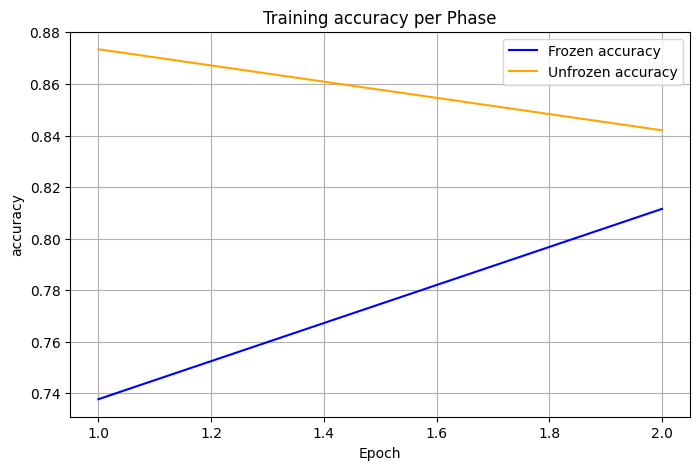

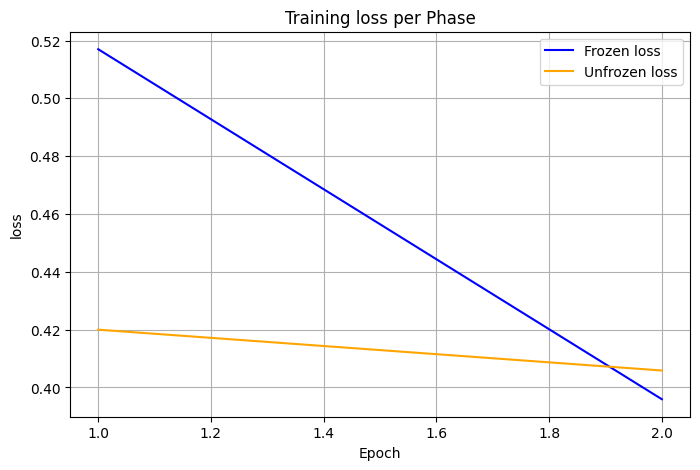

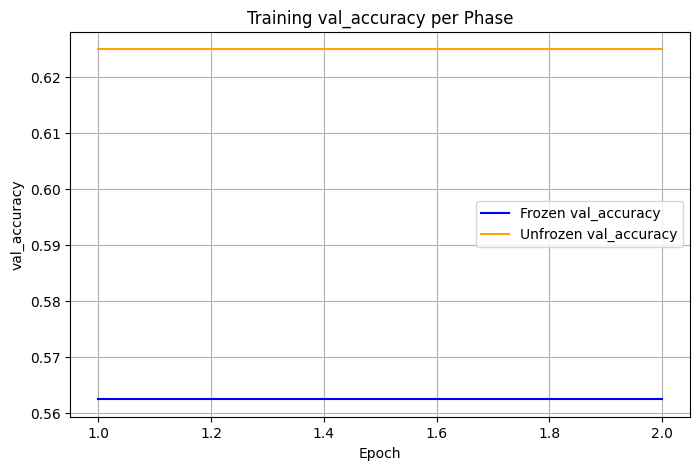

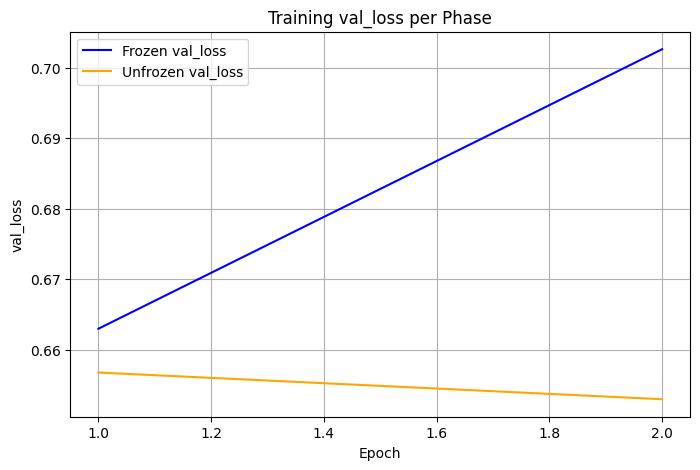

In [ ]:
mlflow.keras.autolog(disable=True) # desactivation du log automatique
with mlflow.start_run(run_name=f"CheXNet-transfer { datetime.now().strftime('%Y-%m-%d %H:%M:%S') }"):
    
    #ajouter des info dans mlflow
    for key, val in tags.items():
        mlflow.set_tag(key, val)
    
    mlflow.log_params(params)
    
    # Modèle basé sur DenseNet121
    input_tensor = layers.Input(shape=(IMAGE_PIXEL[0], IMAGE_PIXEL[1], 3))
    
    #utilisation du modele DenseNet (création sans poids afin de rajouter ceux de CheXNet)
    model_densenet121 = DenseNet121(include_top=False, weights=None, input_tensor=input_tensor)

    x = model_densenet121.output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(14, activation='sigmoid')(x)  # 14 sorties comme CheXNet

    model = models.Model(inputs= model_densenet121.input, outputs=output)

    # Charger les poids de CheXNet (Keras)
    model.load_weights("weights/CheXNet_Keras_0.3.0_weights.h5")

    
    x = model.layers[-2].output     # on reprend la couche GlobalAveragePooling2D
    output = layers.Dense(1, activation='sigmoid')(x)   # Retirer la dernière couche et en ajouter une nouvelle
    model = models.Model(inputs=model.input, outputs=output)

    for layer in model.layers[:-1]:  # Freeze toutes les couches du modèle (sauf la nouvelle couche Dense)
        layer.trainable = False
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)       # éviter le surapprentissage
        
    # Compiler
    model.compile(
        optimizer='adam',                            # Méthode d’optimisation (descente de gradient)
        loss='binary_crossentropy',                  # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
        metrics=['accuracy'])                        # On surveille l’exactitude pendant l'entraînement
    
    history_frozen = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs= params['frozen_epochs'],
    batch_size = 32,
    callbacks=[early_stop]
    )
    
    # Log manuel phase 1 (history_frozen)
    save_log_history(history=history_frozen.history, prefix="frozen")
       
    # 7. Défiger certaines couches + recompiler
    for layer in model.layers[-11:]:
        layer.trainable = True

    # ⚠️ Recompiler après avoir modifié trainable
    model.compile(optimizer=optimizers.Adam(1e-5),  # ← plus petit LR pour ne pas détruire les poids
                loss='binary_crossentropy',
                metrics=['accuracy'])

    # Deuxième phase d'entraînement (fine-tuning)
    history_unfrozen = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs= params['finetune_epochs'],
        batch_size = 32,
        callbacks=[early_stop]
    )
    
    # Log manuel phase 2 (history_unfrozen)
    save_log_history(history=history_unfrozen.history, prefix="unfrozen")

    #tracer les graph
    for metric in history_frozen.history:
        draw_graph({"frozen": history_frozen.history[metric], "unfrozen": history_unfrozen.history[metric] }, metric, 10)
    
    loss, acc = model.evaluate(test_generator)  # -------- Évaluation finale --------
    mlflow.log_metric("final_test_loss", loss)
    mlflow.log_metric("final_test_accuracy", acc)
    
    
    
    # Exemple d'entrée : un batch aléatoire
    input_example = np.random.rand(1, IMAGE_PIXEL[0], IMAGE_PIXEL[1], 3).astype(np.float32)

    # Prédiction pour obtenir un exemple de sortie
    output_example = model.predict(input_example)

    # Déduire la signature
    signature = infer_signature(input_example, output_example)

    # Répertoire persistant, pas dans /tmp
    artifact_dir = "./mlflow_model_artifacts"
    os.makedirs(artifact_dir, exist_ok=True)
    
    import tempfile
    tempfile.tempdir = artifact_dir
    
    mlflow.keras.log_model(
        model,
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )
    
    # Logger les artefacts dans MLflow
    #mlflow.log_artifacts(os.path.join(temp_dir, "model"), artifact_path="model")
    
    # Optionnel : sauvegarder le modèle final
    #mlflow.keras.log_model(model, "CheXNet_final_model")
    #mlflow.keras.log_model(model, artifact_path="CheXNet_model")
    
    # loggage d’un tag pour identifier le type
    mlflow.set_tag("model_type", "Keras CNN")

In [ ]:
def draw_graph(list_val, metric, epochs):
    epochs_frozen = list(range(1, len(list_val['frozen']) + 1))
    epochs_unfrozen = list(range(1, len(list_val['unfrozen']) + 1))
    
    plt.figure()
    plt.plot(epochs_frozen, list_val['frozen'], label=f'Frozen {metric}', color='blue')
    plt.plot(epochs_unfrozen, list_val['unfrozen'], label=f'Unfrozen {metric}', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric}')
    plt.title(f'Training {metric} per Phase')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Sauver l'image
    #plt.savefig(f"img/{metric}_comparison.png")
    
    # Logguer dans MLflow
    #mlflow.log_artifact(f"img/{metric}_comparison.png")


display(history_frozen.history)
display(history_unfrozen.history)

display(history_frozen.history['accuracy'])
display(history_unfrozen.history['accuracy'])

#draw_graph({"frozen": history_frozen.history['accuracy'], "unfrozen": history_unfrozen.history['accuracy'] }, 'accuracy', 10)

#tracer les graph
for metric in history_frozen.history:
    draw_graph({"frozen": history_frozen.history[metric], "unfrozen": history_unfrozen.history[metric] }, metric, 10)

In [ ]:
# Résumé du modèle
model.summary()


In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Accuracy sur le test : {acc*100:.2f}%")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mlflow

# Étape 1 : Prédictions sur les données de test
# (shuffle=False est essentiel pour avoir les bonnes étiquettes dans le bon ordre)
y_pred_proba = model.predict(test_generator)
y_pred = (y_pred_proba > 0.5).astype("int").flatten()

# Étape 2 : Étiquettes vraies
y_true = test_generator.classes

# Étape 3 : Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Affichage avec seaborn
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

# Log sur MLflow
mlflow.log_figure(fig, "confusion_matrix.png")
plt.show()

## 📈 6. Évaluation du modèle & Suivi avec MLflow

Nous entraînons le modèle sur les radios et évaluons ses performances sur l'ensemble de validation.

Dans une logique de **traçabilité expérimentale**, nous utilisons **MLflow** pour :

- enregistrer automatiquement les métriques d'entraînement (loss, accuracy, etc.),
- suivre les paramètres du modèle,
- sauvegarder l'historique des essais pour une future comparaison ou mise en production.

Ceci initie une approche MLOps pour le suivi reproductible de nos expériences.

- lancer mlflow: mlflow ui

In [ ]:
nommage = {0:"NORMAL", 1:"PNEUMONIA"}

# # === Nombre total d'images dans le test_generator
n_images = test_generator.samples

# # === Tirer un indice aléatoire entre 0 et n_images - 1
index = random.randint(0, n_images - 1)

# # === Calculer le batch et la position dans le batch
batch_size = test_generator.batch_size
batch_index = index // batch_size
image_index = index % batch_size

# # === Charger le batch correspondant
images_batch, labels_batch = test_generator[batch_index]

# # === Récupérer l’image et le label à cet index
img = images_batch[image_index]
label = labels_batch[image_index]

# # === Montrer l’image avec le label
plt.imshow(img)
plt.title(f"Label attendu : {nommage[label]}")
plt.axis('off')
plt.show()

# # === Prédiction
img_input = np.expand_dims(img, axis=0)
pred = model.predict(img_input)

# # === Interprétation
display(pred)